In [1]:
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from sklearn.metrics import accuracy_score
from pyts.transformation import ShapeletTransform
from pyts.classification import LearningShapelets

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

import ast

2023-01-06 20:23:18.367344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 20:23:18.579111: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-06 20:23:18.579149: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-06 20:23:19.755405: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Reading DF from .csv

In [2]:
daily_stats = pd.read_csv('daily_stats_user.csv', lineterminator='\n', index_col=0)

### Converting str time series into array

In [3]:
daily_stats['success_ts'] = daily_stats.success_ts.apply(ast.literal_eval)

In [4]:
X_bot = []
y_bot = []

X_nonbot = []
y_nonbot = []

X_topredict = []

for row in daily_stats.itertuples():
    if row.bot == 1:
        X_bot.append(row.success_ts)
        y_bot.append(row.bot)
    elif row.bot == 0:
        X_nonbot.append(row.success_ts)
        y_nonbot.append(row.bot)
    else:
        X_topredict.append(row.success_ts)

X_bot = np.array(X_bot)
y_bot = np.array(y_bot)

X_nonbot = np.array(X_nonbot)
y_nonbot = np.array(y_nonbot)

X = np.concatenate((X_bot,X_nonbot))
y = np.concatenate((y_bot, y_nonbot))

X_topredict = np.array(X_topredict)

### Manually extracting shapelets

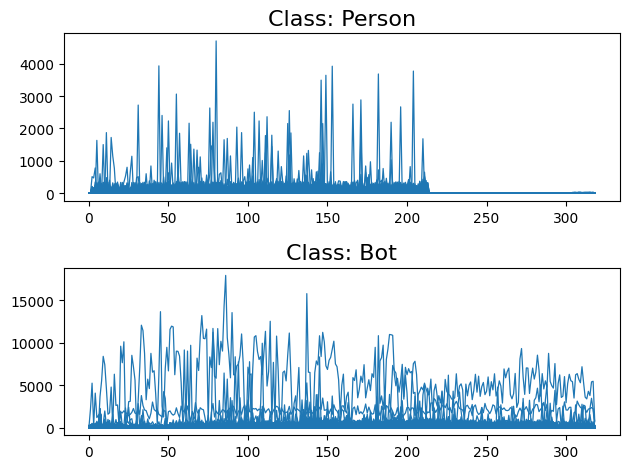

In [5]:
plt.figure()
for i, classe in enumerate(['Person', 'Bot']):
    plt.subplot(2, 1, i + 1)
    for x in range(0, len(X)):
        if y[x] == i:
            plt.plot(X[x], color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

### Shaplet matching

##### computing shaplet sizes

In [6]:
n_ts, ts_sz = X.shape
n_classes = len(set(y))

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.001,
                                                       r=3)
print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 6784
ts_sz 319
n_classes 2
shapelet_sizes {1: 6, 2: 6, 3: 6}


In [7]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=0.001,
                        max_iter=10000,
                        verbose=1,
                        scale=True)

In [8]:
shp_clf.fit(X, y)

2023-01-06 20:24:04.371912: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-06 20:24:04.371962: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-06 20:24:04.372021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PC-di-dufnill): /proc/driver/nvidia/version does not exist
2023-01-06 20:24:04.372641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10000
27/27 [==============================] - 2s 22ms/step - loss: 0.6972 - binary_accuracy: 0.5202 - binary_crossentropy: 0.6957
Epoch 2/10000
27/27 [==============================] - 1s 21ms/step - loss: 0.6963 - binary_accuracy: 0.5343 - binary_crossentropy: 0.6948
Epoch 3/10000
27/27 [==============================] - 1s 21ms/step - loss: 0.6954 - binary_accuracy: 0.5500 - binary_crossentropy: 0.6939
Epoch 4/10000
27/27 [==============================] - 0s 18ms/step - loss: 0.6947 - binary_accuracy: 0.5641 - binary_crossentropy: 0.6932
Epoch 5/10000
27/27 [==============================] - 0s 16ms/step - loss: 0.6939 - binary_accuracy: 0.5709 - binary_crossentropy: 0.6924
Epoch 6/10000
27/27 [==============================] - 1s 22ms/step - loss: 0.6933 - binary_accuracy: 0.5710 - binary_crossentropy: 0.6918
Epoch 7/10000
27/27 [==============================] - 1s 21ms/step - loss: 0.6927 - binary_accuracy: 0.5702 - binary_crossentropy: 0.6912
Epoch 8/10000
27/27 [======

LearningShapelets(n_shapelets_per_size={1: 6, 2: 6, 3: 6}, scale=True,
                  verbose=1, weight_regularizer=0.001)

In [13]:
shp_clf.to_json('model.json')
shp_clf = ShapeletModel.from_json('shapelet_model.json')

In [15]:
predicted_labels = shp_clf.predict(X_topredict)
print(list(predicted_labels).count(1))

2/2 [==============================] - 0s 6ms/step
5


In [16]:
predicted_locations = shp_clf.locate(X)
predicted_locations

27/27 [==============================] - 0s 5ms/step


array([[  0, 192,  56, ...,  54, 261,  54],
       [  0, 141, 104, ..., 139, 104, 102],
       [111, 105, 117, ...,  98, 164, 111],
       ...,
       [  0, 197, 201, ..., 195, 201, 207],
       [  0, 202, 202, ..., 200, 202, 200],
       [  0, 207, 207, ..., 205, 207, 205]])

In [17]:
shp_clf.shapelets_

array([array([[0.0030641]]), array([[0.92687398]]), array([[0.58866477]]),
       array([[0.17725012]]), array([[0.01447883]]),
       array([[0.58866608]]), array([[0.00335899],
                                     [0.00335899]]),
       array([[0.75840467],
              [0.7883237 ]]), array([[0.83866137],
                                     [0.01882328]]),
       array([[0.033168  ],
              [0.58823842]]), array([[0.28307813],
                                     [0.0777078 ]]),
       array([[0.01667121],
              [0.83871204]]), array([[0.02379685],
                                     [0.02972446],
                                     [0.01836397]]),
       array([[1.49844027],
              [1.49197185],
              [1.49156141]]), array([[ 0.10375842],
                                     [ 0.28518885],
                                     [-0.05140408]]),
       array([[-0.19260027],
              [-0.14521451],
              [ 1.21649885]]), array([[0.58865321

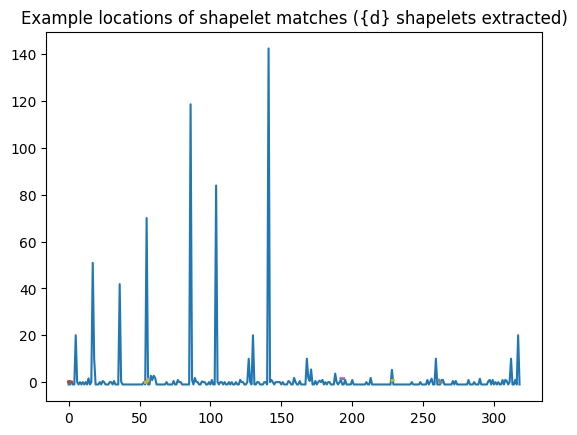

In [26]:
ts_id = 0
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "({d} shapelets extracted)")

plt.plot(X[1])
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

### Extracting shaplets for bots

In [259]:
# st = ShapeletTransform(n_shapelets=5, window_sizes=[int(len(X_bot[0])/2)])
# st.fit(X_bot, y_bot)

SystemError: CPUDispatcher(<function _derive_all_squared_distances_fit at 0x7f688b1d9820>) returned a result with an error set

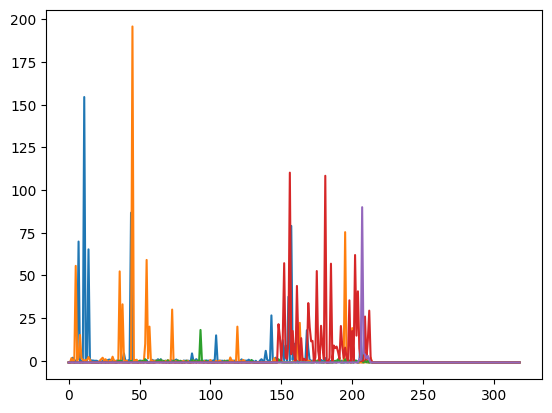

In [ ]:
# for s in st.shapelets_:
#     plt.plot(s)
# plt.show()

# Classification

In [228]:
# randsamp = []
# randw = []
# extracted = []
# while len(randsamp) != 2000:
# 
#     r = random.randint(0, len(X)-1)
#     if r in extracted:
#         continue
#     else:
#         extracted.append(r)
#         randsamp.append(X[r])
#         randw.append(y[r])
# len(randsamp)

# 4000 record corrispondono a 50 secondi

2000

In [254]:
# shp_clf = LearningShapelets(random_state=42, tol=0.01, min_shapelet_length=len(X[0]), n_shapelets_per_size=2, shapelet_scale=1)
# """n_shapelets_per_size=1, shapelet_scale=2,"""

'n_shapelets_per_size=1, shapelet_scale=2,'

In [255]:
# shp_clf.fit(X, y)

ValueError: 'n_shapelets_per_size' is too high given 'min_shapelet_length' and 'shapelet_scale'.

In [243]:
# shp_clf.coef_.shape

(1, 1)

In [244]:
# Select three shapelets
# sel_shapelets = np.asarray(shp_clf.shapelets_[0])

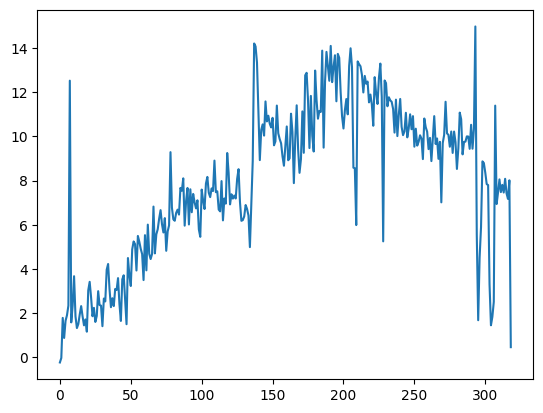

In [245]:
# for s in sel_shapelets:
#     plt.plot(s)
# plt.show()